# Poisson regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

In [2]:
# Generate artificial data (but based on true evidence)

# decide poisson theta values
theta_noalcohol_meds = 1    # no alcohol, took an antihist
theta_alcohol_meds = 3      # alcohol, took an antihist
theta_noalcohol_nomeds = 6  # no alcohol, no antihist
theta_alcohol_nomeds = 36   # alcohol, no antihist

# create samples
q = 20
df = pd.DataFrame({
        'nsneeze': np.concatenate((np.random.poisson(theta_noalcohol_meds, q),
                                   np.random.poisson(theta_alcohol_meds, q),
                                   np.random.poisson(theta_noalcohol_nomeds, q), 
                                   np.random.poisson(theta_alcohol_nomeds, q))),
        'alcohol': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'nomeds': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})
df.head()

,nsneeze,alcohol,nomeds
0,1,False,False
1,0,False,False
2,2,False,False
3,0,False,False
4,0,False,False


In [3]:
df.groupby(['alcohol','nomeds']).mean().unstack()

nsneeze       
nomeds    False  True 
alcohol               
False      0.85   5.35
True       3.05  37.40

/home/mike/work/python/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


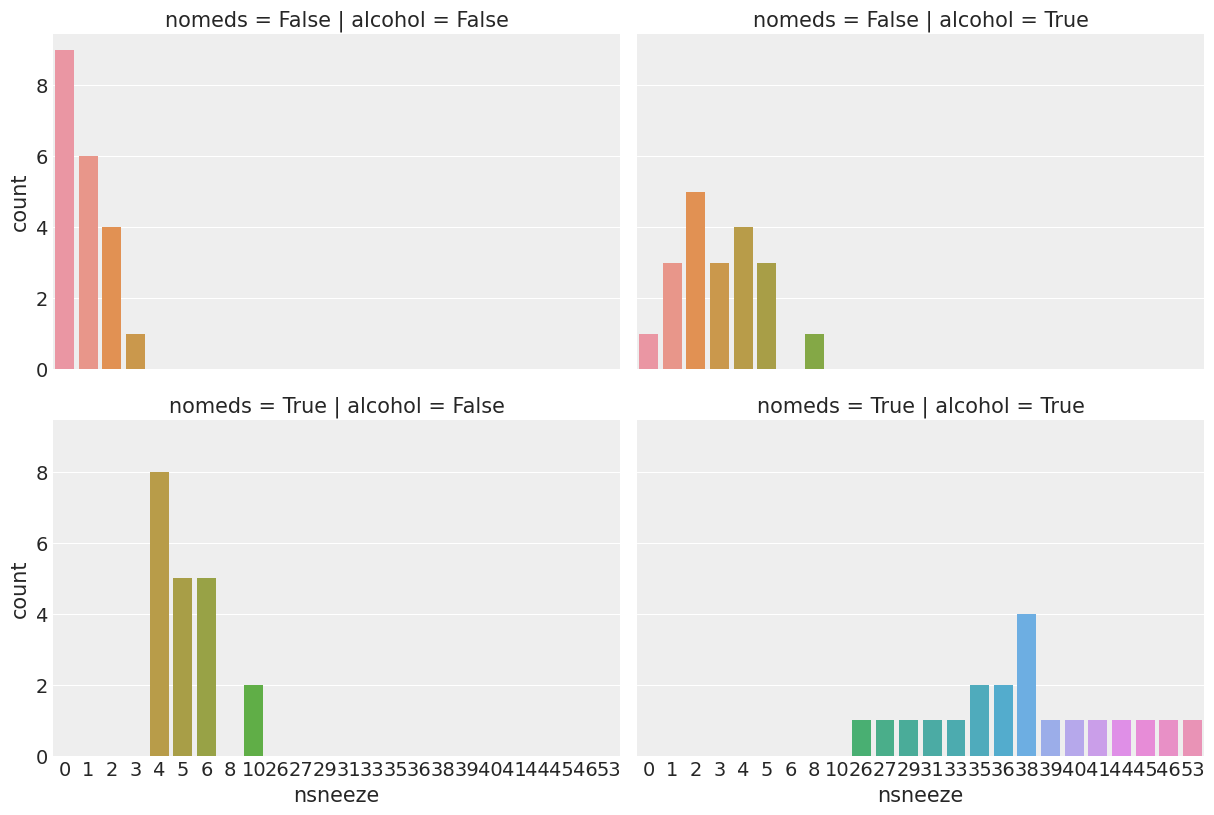

In [4]:
g = sns.catplot(x='nsneeze', row='nomeds', col='alcohol', data=df,
                kind='count', height=4, aspect=1.5)

In [5]:
# transform group predictors to indicators

df['intercept'] = 1
df['alcohol_true'] = df['alcohol'].astype('float')
df['nomeds_true'] = df['nomeds'].astype('float')
df['nomeds_alcohol_true'] = (df['alcohol'] & df['nomeds']).astype('float')

In [6]:
X = df[['intercept', 'alcohol_true', 'nomeds_true', 'nomeds_alcohol_true']]
t = df['nsneeze']
X[:5]

,intercept,alcohol_true,nomeds_true,nomeds_alcohol_true
0,1,0.0,0.0,0.0
1,1,0.0,0.0,0.0
2,1,0.0,0.0,0.0
3,1,0.0,0.0,0.0
4,1,0.0,0.0,0.0


## model:
$$
t_i | \mathbf x_i, \mathbf w \sim \mathrm{Pois}(\lambda(\mathbf x_i)), \quad i=1\ldots n,
\\
\lambda(\mathbf x) = e^{\mathbf w^T \mathbf x }
\\
w_j \sim N(0, 10), \quad j=0,1,2,3
$$

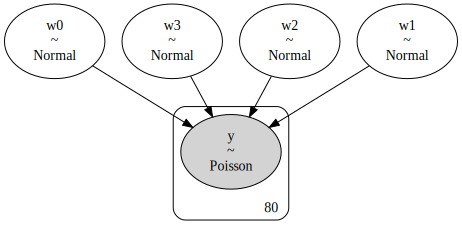

In [7]:
with pm.Model() as model:    
    w0 = pm.Normal('w0', mu=0, sigma=10)
    w1 = pm.Normal('w1', mu=0, sigma=10)
    w2 = pm.Normal('w2', mu=0, sigma=10)
    w3 = pm.Normal('w3', mu=0, sigma=10)
    # define linear model and exp link function
    lmbda = w0 + \
            w1 * X['alcohol_true'] + \
            w2 * X['nomeds_true'] + \
            w3 * X['nomeds_alcohol_true']
    ## Define Poisson likelihood
    output = pm.Poisson('y', mu=np.exp(lmbda), observed=t)
    
pm.model_to_graphviz(model)

In [8]:
with model:
    trace = pm.sample(2000, tune=2000, chains=2, cores=2,
                     return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w3, w2, w1, w0]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.700898349804191, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


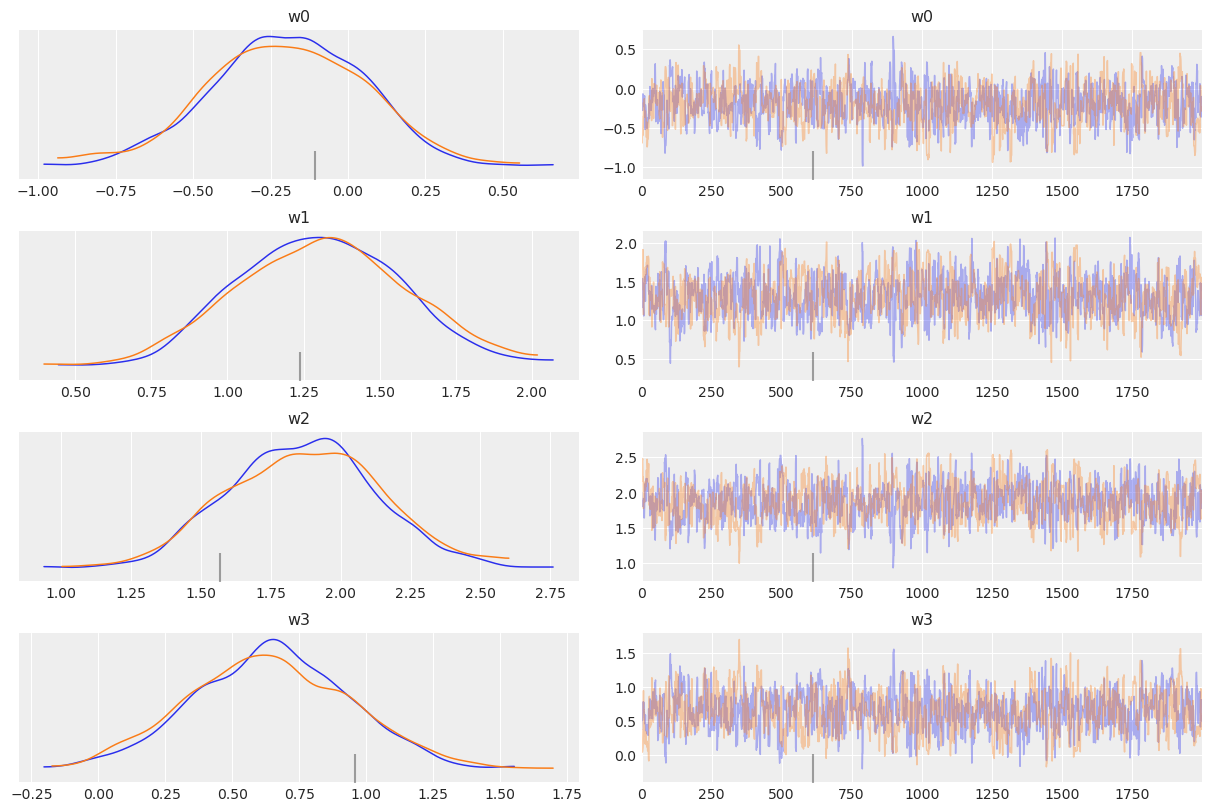

In [9]:
az.plot_trace(trace, compact=False);

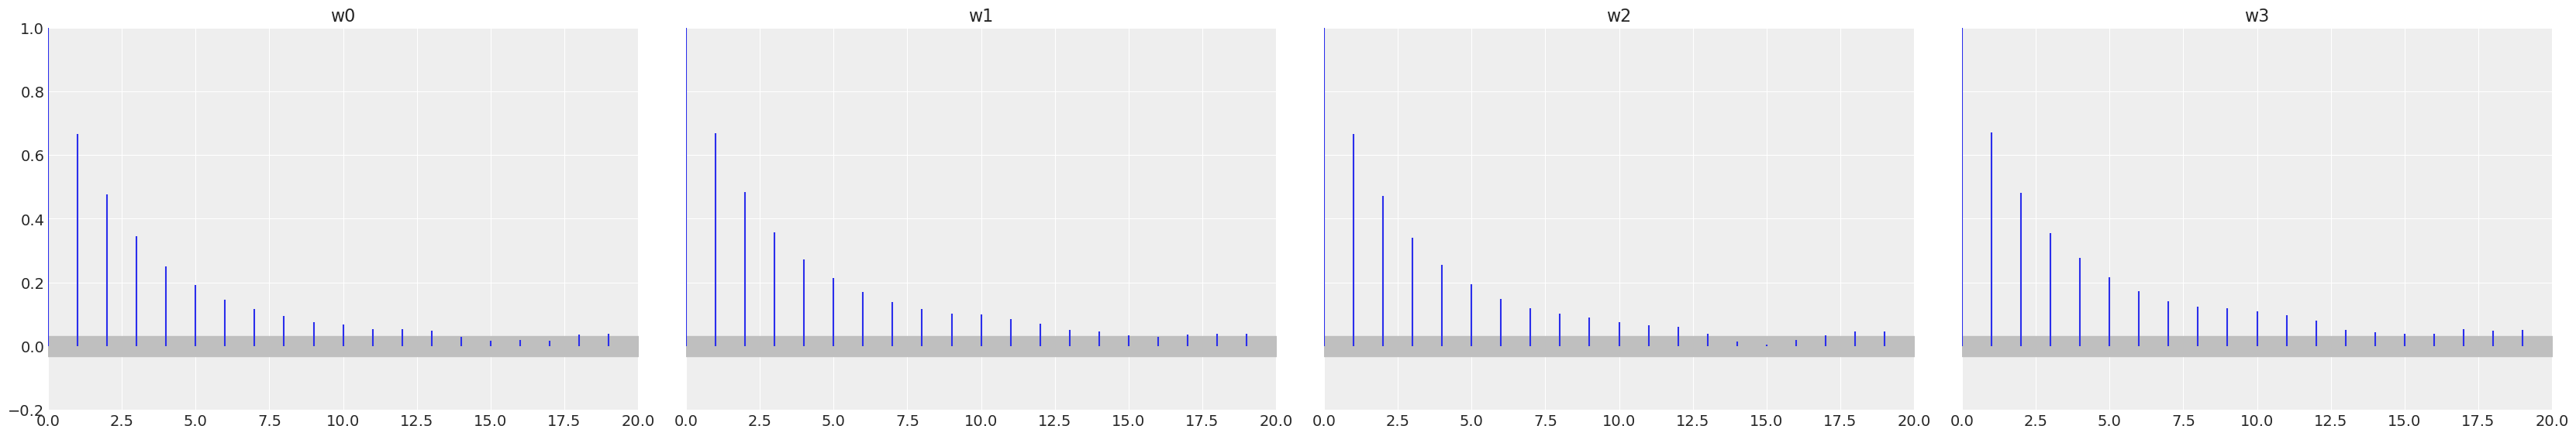

In [10]:
az.plot_autocorr(trace, max_lag=20, combined=True)
plt.ylim([-0.2, 1]);

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,-0.198,0.246,-0.655,0.253,0.010,0.007,615.0,850.0,1.0
w1,1.308,0.274,0.802,1.808,0.012,0.008,538.0,756.0,1.0
w2,1.866,0.266,1.345,2.327,0.011,0.008,623.0,792.0,1.0
w3,0.643,0.293,0.114,1.217,0.013,0.009,530.0,732.0,1.0


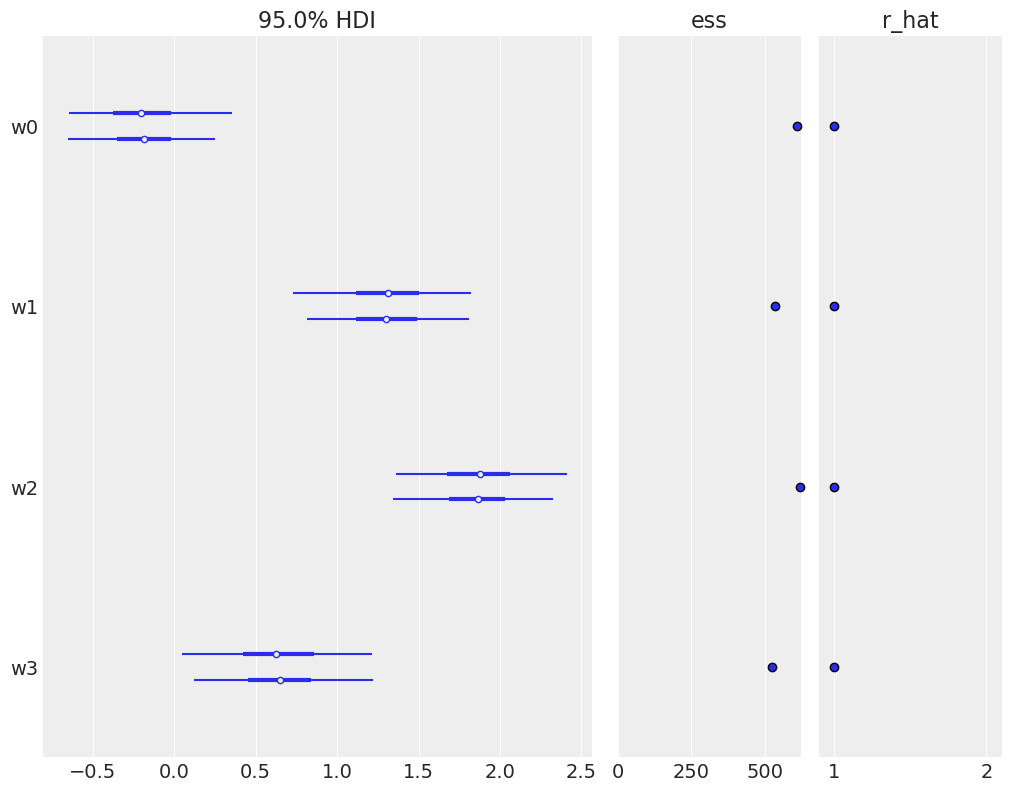

In [12]:
az.plot_forest(trace,
               hdi_prob=0.95,
               r_hat=True, ess=True);

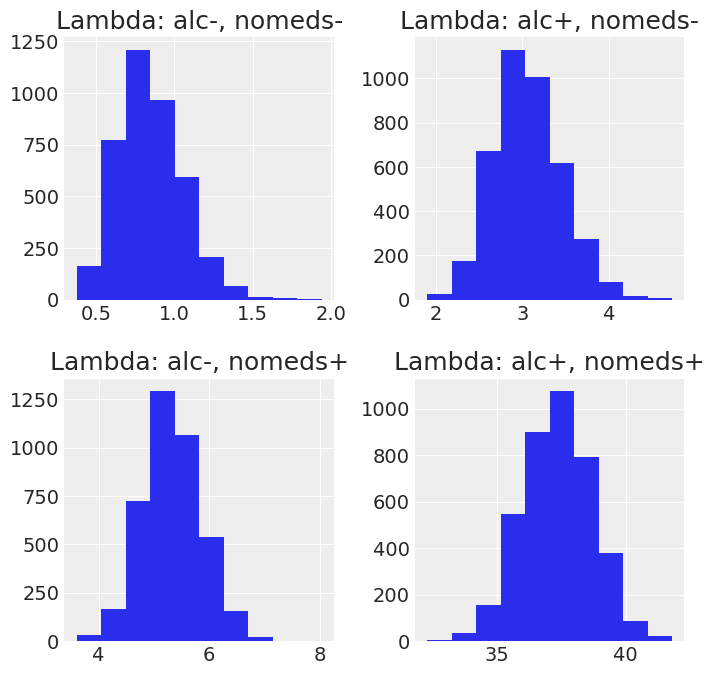

In [13]:
trace_w0 = trace.posterior['w0'].values.reshape(-1)
trace_w1 = trace.posterior['w1'].values.reshape(-1)
trace_w2 = trace.posterior['w2'].values.reshape(-1)
trace_w3 = trace.posterior['w3'].values.reshape(-1)

lmbda00_sample = np.exp(trace_w0)
lmbda10_sample = np.exp(trace_w0 + trace_w1)
lmbda01_sample = np.exp(trace_w0 + trace_w2)
lmbda11_sample = np.exp(trace_w0 + trace_w1 + trace_w2 + trace_w3)

plt.figure(figsize=(8, 8), constrained_layout=False)

# alc-, nomeds-
plt.subplot(2, 2, 1)
plt.title('Lambda: alc-, nomeds-', fontsize=18)
plt.hist(lmbda00_sample)

# alc+
plt.subplot(2, 2, 2)
plt.title('Lambda: alc+, nomeds-', fontsize=18)
plt.hist(lmbda10_sample)

# nomeds+
plt.subplot(2, 2, 3)
plt.title('Lambda: alc-, nomeds+', fontsize=18)
plt.hist(lmbda01_sample)

# alc+, nomeds+
plt.subplot(2, 2, 4)
plt.title('Lambda: alc+, nomeds+', fontsize=18)
plt.hist(lmbda11_sample)

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
plt.show()

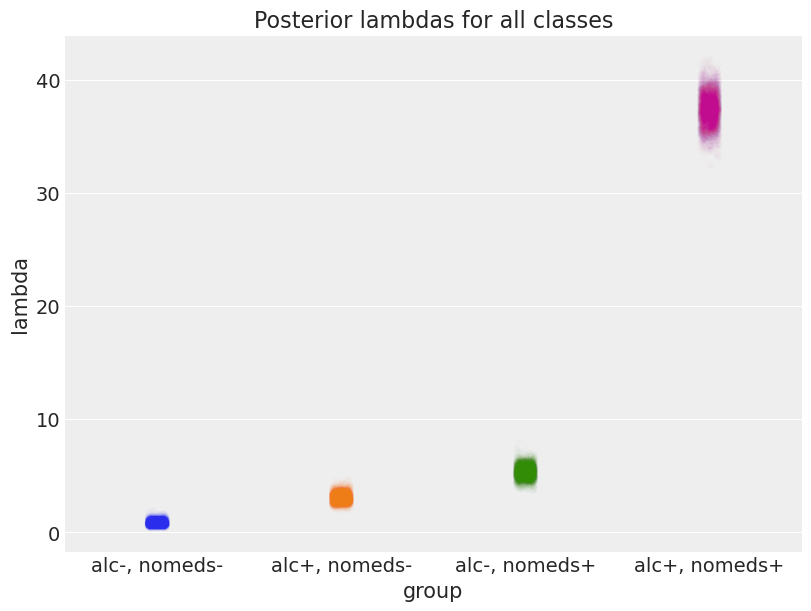

In [14]:
z = pd.DataFrame({
        'lambda': np.concatenate([lmbda00_sample,
                                 lmbda10_sample,
                                 lmbda01_sample, 
                                 lmbda11_sample]),
        'group': np.concatenate([np.repeat('alc-, nomeds-', len(lmbda00_sample)),
                                 np.repeat('alc+, nomeds-', len(lmbda10_sample)),
                                 np.repeat('alc-, nomeds+', len(lmbda01_sample)),
                                 np.repeat('alc+, nomeds+', len(lmbda11_sample))])
})

plt.figure(figsize=(8, 6))
plt.title('Posterior lambdas for all classes')
sns.stripplot(x="group", y="lambda", data=z, alpha=0.01, jitter=0.05);